# Benchmarking agents

So far we have been revolving around the agents based on Q-learning. However, we can implement other optimization schemes. Here, we compare the performance of the reinforcement learning approach with Breadth First Search (BFS) and Monte Carlo (MC) optimization.   

In [ ]:
from bounce.sdp import SdPEnergySolver
from bounce.environment import SdPEnvironment
from bounce.hamiltonian import XXHamiltonian, Chain1D
from bounce.training import DQNTrainer, BrFSTrainer, MCTrainer
from bounce.utils import state2str, arrange_shape, best_so_far, save_benchmark, load_benchmark

import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

%matplotlib inline

## Comparing the performance in the same problem

Let us start by defining a Hamiltonian and comparing the exploration capabilities of the three algorithms. 

First, define the problem parameters.

In [ ]:
N = 6

# Environment
B, J = 1, [i%3 for i in range(N)]
H = XXHamiltonian(Chain1D(N), B, J)
solver = SdPEnergySolver()
budget = 305
env = SdPEnvironment(H, solver, budget)

# Training parameters
episodes = 375
time_steps = 8
opt = (-17.4164, 195) 
best_ref = np.array([*opt, 300])
n_agents, jobs = 10, 10 # Number of agents to train and parallel threads

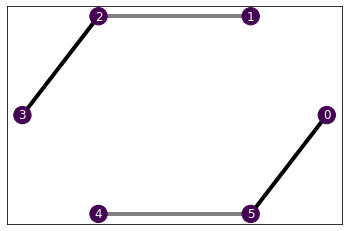

In [ ]:
H.draw()

Define the different agents that are to be compared.

In [ ]:
learning_rate = 5e-3
batch_size = 160
eps_decay = 0.95

In [ ]:
dqn = DQNTrainer(env, n_agents=n_agents, n_jobs=jobs, 
                 learning_rate=learning_rate, batch_size=batch_size, 
                 eps_decay=eps_decay)

brfs = BrFSTrainer(env, n_agents=n_agents, n_jobs=jobs)

mc = MCTrainer(env, n_agents=n_agents, n_jobs=jobs)

Train!

In [ ]:
%time dqn_results = dqn.train(episodes, time_steps=time_steps, opt=opt, best_ref=best_ref, ckp=10)

In [ ]:
max_states = int(0.4*episodes*time_steps)
%time brfs_results = brfs.train(max_states, opt=opt, best_ref=best_ref)

In [ ]:
%time mc_results = mc.train(max_states, opt=opt, best_ref=best_ref)

Let's see the results. We will compare the average reward and the average best obtained reward of every new visited state. These rewards are computed with respect to the `best_ref` parameter, which provides all the information about the optimal and suboptimal states. 

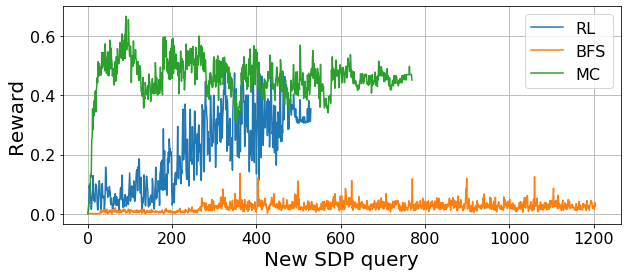

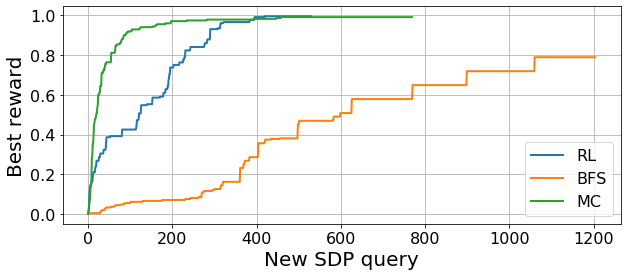

In [ ]:
dqn_expl = dqn_results["exploration"]
dqn_rewards = arrange_shape(dqn_expl['oracle_rewards'])
brfs_rewards = arrange_shape(brfs_results['oracle_rewards'])
mc_rewards = arrange_shape(mc_results['oracle_rewards'])

plt.figure(figsize=(10, 4))
plt.plot(np.mean(dqn_rewards, axis=0), label="RL")
plt.plot(np.mean(brfs_rewards, axis=0), label="BFS")
plt.plot(np.mean(mc_rewards, axis=0), label="MC")
plt.grid()
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.xlabel("New SDP query", fontsize=20)
plt.ylabel("Reward", fontsize=20)


plt.figure(figsize=(10, 4))
plt.plot(np.mean(best_so_far(dqn_rewards), axis=0), linewidth=2, label="RL")
plt.plot(np.mean(best_so_far(brfs_rewards), axis=0), linewidth=2, label="BFS")
plt.plot(np.mean(best_so_far(mc_rewards), axis=0), linewidth=2, label="MC")
plt.grid()
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.xlabel("New SDP query", fontsize=20)
plt.ylabel("Best reward", fontsize=20);

## Benchmarking for different system sizes

One of the main results shown in the paper is the benchmarking of the reinforcement learning approach with the other optimization algorithms. Here we provide the source code used to perform both benchmarks: the one allowing half of the 3-body constraints and one allowing all the 3-body constraints. 

Execute either of the two cells below to set up the parameters. Beware that the simulations may take quite long and that you may have to adapt the `jobs` parameter (number of parallel threads) such that the task fits into GPU memory. Benchmarks up to $N=14$ take reasonable time. The results can be plotted in the _04_plots.ipynb_ notebook, where the paper plots can be found as reference.  

In [ ]:
file_suffix = "half_3"
configs = {5:  {'opt': (-7.4721, 79),   'worst': 132, 'max_limit': 135, 'episodes': 100, 'decay': 0.5, 'jobs': 17},
           6:  {'opt': (-10.9443, 127), 'worst': 180, 'max_limit': 185, 'episodes': 200, 'decay': 0.5, 'jobs': 17},
           7:  {'opt': (-11.9443, 131), 'worst': 192, 'max_limit': 195, 'episodes': 200, 'decay': 0.5, 'jobs': 17},
           8:  {'opt': (-12.9443, 143), 'worst': 240, 'max_limit': 245, 'episodes': 375, 'decay': 0.95, 'jobs': 17},
           9:  {'opt': (-16.4164, 191), 'worst': 252, 'max_limit': 255, 'episodes': 375, 'decay': 0.95, 'jobs': 17},
           10: {'opt': (-17.4164, 195), 'worst': 300, 'max_limit': 305, 'episodes': 375, 'decay': 0.95, 'jobs': 17},
           11: {'opt': (-18.4164, 207), 'worst': 312, 'max_limit': 315, 'episodes': 450, 'decay': 0.95, 'jobs': 17},
           12: {'opt': (-21.8885, 255), 'worst': 360, 'max_limit': 365, 'episodes': 500, 'decay': 0.95, 'jobs': 17},
           13: {'opt': (-22.8885, 259), 'worst': 372, 'max_limit': 375, 'episodes': 500, 'decay': 0.95, 'jobs': 17},
           14: {'opt': (-23.8885, 271), 'worst': 420, 'max_limit': 425, 'episodes': 675, 'decay': 0.95, 'jobs': 17},
           15: {'opt': (-27.3607, 319), 'worst': 432, 'max_limit': 435, 'episodes': 675, 'decay': 0.95, 'jobs': 17},
           16: {'opt': (-28.3607, 323), 'worst': 480, 'max_limit': 485, 'episodes': 700, 'decay': 0.95, 'jobs': 17},
           17: {'opt': (-29.3607, 335), 'worst': 492, 'max_limit': 500, 'episodes': 800, 'decay': 0.98, 'jobs': 17},
           18: {'opt': (-32.8328, 383), 'worst': 540, 'max_limit': 545, 'episodes': 750, 'decay': 0.98, 'jobs': 15},
           19: {'opt': (-33.8328, 383), 'worst': 552, 'max_limit': 555, 'episodes': 750, 'decay': 0.98, 'jobs': 15}
           }
temp = 0.084 # Monte Carlo temperature

In [ ]:
file_suffix = "all_3"
configs = {5:  {'opt': (-7.4721, 79),   'worst': 240, 'max_limit': 245, 'episodes': 100, 'decay': 0.5, 'jobs': 17},
           6:  {'opt': (-10.9443, 127), 'worst': 288, 'max_limit': 300, 'episodes': 200, 'decay': 0.5, 'jobs': 17},
           7:  {'opt': (-11.9443, 131), 'worst': 336, 'max_limit': 340, 'episodes': 200, 'decay': 0.5, 'jobs': 17},
           8:  {'opt': (-12.9443, 143), 'worst': 385, 'max_limit': 385, 'episodes': 400, 'decay': 0.95, 'jobs': 17},
           9:  {'opt': (-16.4164, 191), 'worst': 432, 'max_limit': 435, 'episodes': 400, 'decay': 0.95, 'jobs': 17},
           10: {'opt': (-17.4164, 195), 'worst': 480, 'max_limit': 485, 'episodes': 400, 'decay': 0.95, 'jobs': 17},
           11: {'opt': (-18.4164, 207), 'worst': 528, 'max_limit': 530, 'episodes': 500, 'decay': 0.95, 'jobs': 17},
           12: {'opt': (-21.8885, 255), 'worst': 576, 'max_limit': 580, 'episodes': 600, 'decay': 0.95, 'jobs': 17},
           13: {'opt': (-22.8885, 259), 'worst': 624, 'max_limit': 625, 'episodes': 600, 'decay': 0.95, 'jobs': 17},
           14: {'opt': (-23.8885, 271), 'worst': 672, 'max_limit': 675, 'episodes': 1000, 'decay': 0.95, 'jobs': 17},
           15: {'opt': (-27.3607, 319), 'worst': 720, 'max_limit': 725, 'episodes': 1100, 'decay': 0.95, 'jobs': 17},
           16: {'opt': (-28.3607, 323), 'worst': 768, 'max_limit': 770, 'episodes': 1100, 'decay': 0.95, 'jobs': 17},
           17: {'opt': (-29.3607, 335), 'worst': 816, 'max_limit': 820, 'episodes': 1500, 'decay': 0.98, 'jobs': 17},
           }
temp = 0.097 # Monte Carlo temperature

In [ ]:
Ns = np.arange(5, 17)

n_agents = 60

lr = 5e-3
bm = 20
eps_0 = 0.9

for N in tqdm(Ns):
    N = int(N)
    config = configs[N]
    B, J = 1, [i%3 for i in range(N)]
    H = XXHamiltonian(Chain1D(N), B, J)
    budget = config['max_limit']
    env = SdPEnvironment(H, SdPEnergySolver(), budget)
    
    episodes, eps_decay, n_jobs = config['episodes'], config['decay'], config['jobs']
    opt, worst = config['opt'], config['worst']
    time_steps = int(1.1*N)
    batch_size = time_steps*bm
    best_ref = np.array([*opt, worst])
    max_states = int(episodes*time_steps*0.35) # Maximum number of states allowed for MC and BFS
    
    # Monte Carlo optimization
    mc = MCTrainer(env, n_agents=n_agents, n_jobs=17, beta=temp)
    mc_results = mc.train(max_states, opt=opt, best_ref=best_ref, ckp=5, break_opt=True)
    save_benchmark(mc_results, N, H, 'MC', suffix=file_suffix)
    del mc; del mc_results
    
    # RL optimization
    id0 = 0
    dqn = DQNTrainer(env, n_agents=n_agents, n_jobs=n_jobs, learning_rate=lr, 
                     batch_size=batch_size, eps_decay=eps_decay, eps_0=eps_0)
    dqn_results = dqn.train(episodes, time_steps=time_steps, opt=opt, best_ref=best_ref, ckp=2,
                            id0=id0, break_opt=True, save=False)
    save_benchmark(dqn_results, N, H, 'DQN', suffix=file_suffix)
    del dqn; del dqn_results    
    
    # BFS
    bfs = BrFSTrainer(env, n_agents=n_agents, n_jobs=n_jobs)
    bfs_results = bfs.train(max_states, opt=opt, best_ref=best_ref, break_opt=True)
    save_benchmark(bfs_results, N, H, 'BFS', suffix=file_suffix)
    del bfs; del bfs_results

    # Random walk        
#     rnd = MCTrainer(env, n_agents=n_agents, n_jobs=n_jobs, beta=10000)
#     rnd_results = rnd.train(max_states, opt=opt, best_ref=best_ref, break_opt=True)
#     save_benchmark(rnd_results, N, H, 'RND', suffix=file_suffix)
#     del rnd; del rnd_results